# Titanic case study E&Y

Data source: https://www.kaggle.com/datasets/vinicius150987/titanic3

Features:
    PClass - třída, hodnoty 1,2,3
    Survived - ano(1)/ne(0)
    Name - jméno
    sex - pohlaví
    age - věk
    sibsp - počet sourozenců na palubě
    parch - počet rodičů/dětí na palubě
    ticekt - číslo lístku
    fare - cena lístku
    cabin - pokoj
    embarked - přístav nalodění(C = Cherbourg, Q = Queenstown, S = Southampton)
    boat - číslo záchranného člunu (pokud survived ano)
    body - číslo vyloveného těla (survived no)
    home.dest - cílová destinace

In [376]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from scipy import stats
import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras import metrics

In [377]:
df = pd.read_excel('data/titanic3.xls')
df.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [379]:
# dropnutí Name a dalších features s velkým počtem chybějících hodnot a malou výpovědní hodnotou
df = df.drop(['name','ticket','cabin','boat','body','home.dest'], axis=1)
df['survived'] = df['survived'].replace({1 : 'yes', 0 : 'no'})
df['embarked'] = df['embarked'].replace({'S' : 'Southampton', 'C' : 'Cherbourg', 'Q' : 'Queenstown'})

In [380]:
df.describe()

,pclass,age,sibsp,parch,fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479
std,0.837836,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


In [381]:
df.isnull().sum()

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

## Chybějící hodnoty
V numerických sloupcích chybějí hodnoty ve sloupcích age a fare, z kategorických proměnných chybí dvě hodnoty ve sloupci embarked
    k vyřešení tohoto problému lze přistupovat několika způsoby, viz finkce missingValues

In [382]:
def missingValues(df, approach):
    if approach == 'mean':
        df['age'] = df['age'].fillna(df['age'].mean())
        df['fare'] = df['fare'].fillna(df['fare'].mean())
        df.dropna(inplace = True)
    else:
        pass

In [383]:
missingValues(df,'mean')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1307 non-null   int64  
 1   survived  1307 non-null   object 
 2   sex       1307 non-null   object 
 3   age       1307 non-null   float64
 4   sibsp     1307 non-null   int64  
 5   parch     1307 non-null   int64  
 6   fare      1307 non-null   float64
 7   embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 91.9+ KB


## EDA

### distribuce hodnot

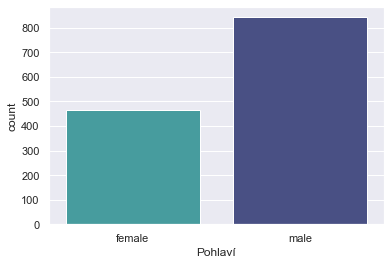

In [384]:
#cílová proměnná
sns.countplot(x='sex',data =  df, palette="mako_r")
plt.xlabel('Pohlaví')
plt.show()

In [385]:
df['sex'].value_counts()

male      843
female    464
Name: sex, dtype: int64

Cílová proměnná je nevybalancovaná -> před modelováním SMOTE

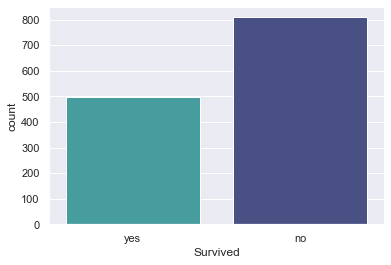

In [386]:
sns.countplot(x='survived',data =  df, palette="mako_r")
plt.xlabel('Survived')
plt.show()

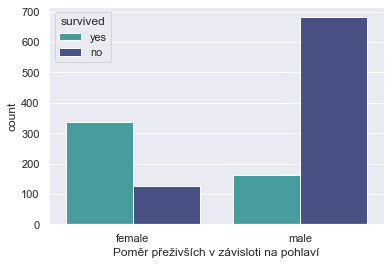

In [387]:
sns.countplot(x='sex', hue='survived',data =  df, palette="mako_r")
plt.xlabel('Poměr přeživších v závisloti na pohlaví')
plt.show()

In [388]:
df.value_counts(['sex','survived'])

sex     survived
male    no          682
female  yes         337
male    yes         161
female  no          127
dtype: int64

Velká zavislost proměnných sex a survived, většina žen přežila, zatímco u mužů tomu bylo právě naopak

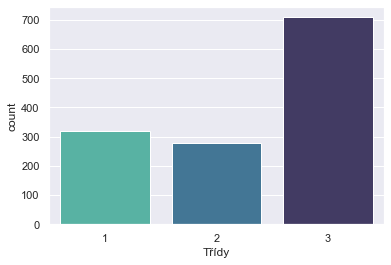

In [389]:
sns.countplot(x='pclass',data =  df, palette="mako_r")
plt.xlabel('Třídy')
plt.show()

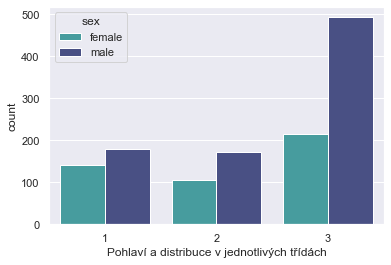

In [390]:
sns.countplot(x='pclass' ,data =  df,hue='sex', palette="mako_r")
plt.xlabel('Pohlaví a distribuce v jednotlivých třídách')
plt.show()

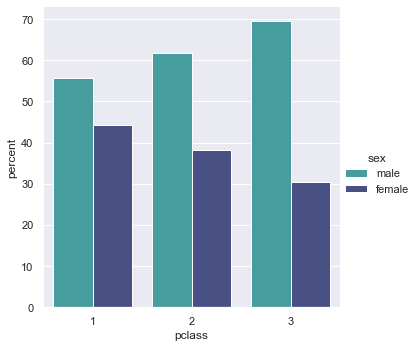

In [391]:
x,y = 'pclass', 'sex'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',palette="mako_r"))

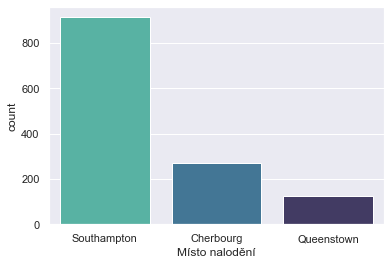

In [392]:
sns.countplot(x='embarked',data =  df, palette="mako_r")
plt.xlabel('Místo nalodění')
plt.show()

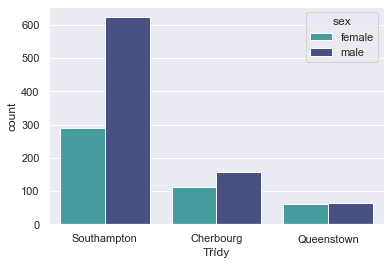

In [393]:
sns.countplot(x='embarked',data =  df,hue='sex', palette="mako_r")
plt.xlabel('Třídy')
plt.show()

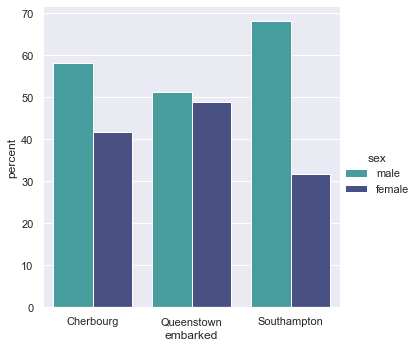

In [394]:
x,y = 'embarked', 'sex'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',palette="mako_r"))

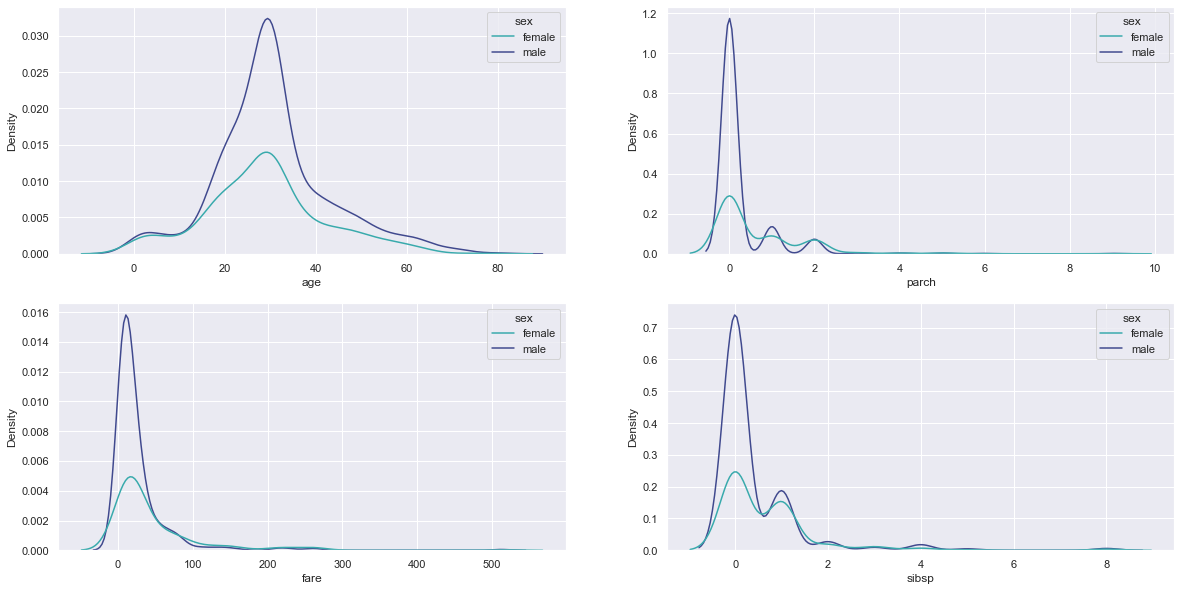

In [395]:
fig,axes=plt.subplots(2,2,figsize=(20,10))

sns.kdeplot( x=df['age'], hue=df['sex'],ax=axes[0,0],palette="mako_r")

sns.kdeplot(x=df['fare'], hue=df['sex'],ax=axes[1,0],palette="mako_r")

sns.kdeplot(x=df['parch'], hue=df['sex'], ax=axes[0,1],palette="mako_r")

sns.kdeplot(x=df['sibsp'], hue=df['sex'], ax=axes[1,1],palette="mako_r")
plt.show()

Z EDA vyplývá, že největší závislot je u proměnné survived, kde přežilo více žen než mužů. Menší trend je i u proměnné pclass a embarked, u nominálních proměnných nelze vypozorovat žádné významné trendy v závisloti s cílovou proměnnou

## Feature engineering

In [396]:
def familyAb(row):
    if (row['sibsp'] + row['parch']) > 0:
        return True
    else:
        return False

In [397]:
#df['familyAboard'] = df.apply(lambda row: familyAb(row) , axis=1)

In [398]:
# df['sibsp'] = df['sibsp'].astype('bool')
# df['parch'] = df['parch'].astype('bool')
#
#
# enc = OneHotEncoder(handle_unknown='ignore')
#
# enc_df = pd.DataFrame(enc.fit_transform(df[['survived','pclass','embarked','sibsp','parch']]).toarray())
#
# enc_df.columns = enc.get_feature_names(['survived','pclass','embarked','sibsp','parch'])
#
# df = df.join(enc_df)
#
# df = df.drop(['survived','pclass','embarked','sibsp','parch'], axis = 1)
#
# df

In [399]:
dfEmb = df

enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['survived','pclass','embarked']]).toarray())

enc_df.columns = enc.get_feature_names(['survived','pclass','embarked'])

df = df.join(enc_df)

df = df.drop(['survived','pclass','embarked'], axis = 1)

df

,sex,age,sibsp,parch,fare,survived_no,survived_yes,pclass_1,pclass_2,pclass_3,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton
0,female,29.000000,0,0,211.3375,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,male,0.916700,1,2,151.5500,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,female,2.000000,1,2,151.5500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,male,30.000000,1,2,151.5500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,female,25.000000,1,2,151.5500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,female,14.500000,1,0,14.4542,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1305,female,29.881135,1,0,14.4542,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1306,male,26.500000,0,0,7.2250,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1307,male,27.000000,0,0,7.2250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [400]:
df.isnull().sum()

sex                     0
age                     0
sibsp                   0
parch                   0
fare                    0
survived_no             2
survived_yes            2
pclass_1                2
pclass_2                2
pclass_3                2
embarked_Cherbourg      2
embarked_Queenstown     2
embarked_Southampton    2
dtype: int64

In [401]:
df = df.dropna()

## Modely

In [402]:
df['sex'] = df['sex'].replace({'female' : 1, 'male' : 0})
X = df.drop(['sex'], axis = 1)
y = df['sex']
y = y.astype('int')

C:\Users\mates\AppData\Local\Temp/ipykernel_14516/1090268639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'] = df['sex'].replace({'female' : 1, 'male' : 0})


In [403]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=101)

In [404]:
ros = RandomOverSampler(sampling_strategy = "not majority")

X_train, y_train = ros.fit_resample(X_train,y_train)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

In [405]:
DTclassifier = DecisionTreeClassifier(max_leaf_nodes=10)
DTclassifier.fit(train_scaled, y_train)

y_pred = DTclassifier.predict(test_scaled)


print(f'Accuracy: {accuracy_score(y_test,y_pred):.2f}')
print(f'Precision: {precision_score(y_test,y_pred):.2f}')
print(f'Recall: {recall_score(y_test,y_pred):.2f}')

Accuracy: 0.67
Precision: 0.56
Recall: 0.51


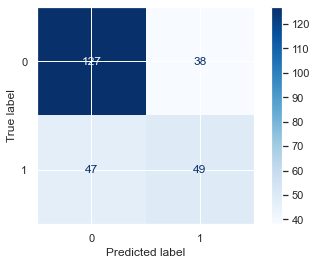

In [406]:
plot_confusion_matrix(DTclassifier, test_scaled, y_test,
                                 cmap=plt.cm.Blues,)

plt.show()

In [407]:
#vypis parametru
params = {
        'n_estimators': stats.randint(150, 1000),
        'learning_rate': stats.uniform(0.01, 0.6),
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0,2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [6,7,8,9,10]

        }
xgb = XGBClassifier()
#vyber nejlepsich parametru
rs = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, n_jobs=4, cv=5, verbose=3, random_state=1001 )
#trenovani
rs.fit(train_scaled, y_train)

#predikce
y_pred = rs.best_estimator_.predict(test_scaled)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\mates\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.7397212  0.75745524 0.73007243        nan]
  warnings.warn(
C:\Users\mates\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:21:03] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [408]:
print(f'Accuracy: {accuracy_score(y_test,y_pred):.2f}')
print(f'Precision: {precision_score(y_test,y_pred):.2f}')
print(f'Recall: {recall_score(y_test,y_pred):.2f}')

Accuracy: 0.64
Precision: 0.51
Recall: 0.50


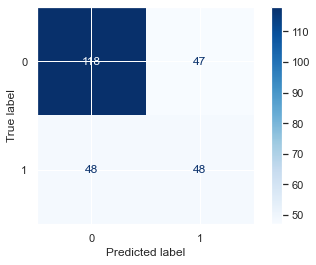

In [409]:
plot_confusion_matrix(rs.best_estimator_, test_scaled, y_test,
                                 cmap=plt.cm.Blues)

plt.show()

In [410]:
LRclassifier = LogisticRegression(solver='liblinear', max_iter=5000)
LRclassifier.fit(train_scaled, y_train)

y_pred = LRclassifier.predict(test_scaled)

print(f'Accuracy: {accuracy_score(y_test,y_pred):.2f}')
print(f'Precision: {precision_score(y_test,y_pred):.2f}')
print(f'Recall: {recall_score(y_test,y_pred):.2f}')


Accuracy: 0.68
Precision: 0.57
Recall: 0.51


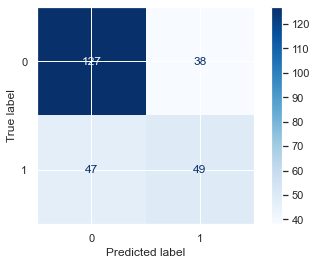

In [411]:
plot_confusion_matrix(DTclassifier, test_scaled, y_test,
                                 cmap=plt.cm.Blues,)

plt.show()

In [412]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(len(X.columns),)),
  tf.keras.layers.Dense(32, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation=tf.nn.relu),
  # tf.keras.layers.Dropout(0.2),
  # tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
               metrics=[
                       'accuracy'
              ])



In [413]:
hist = model.fit(train_scaled, y_train,validation_data=(test_scaled, y_test), epochs=23,  shuffle = True)


Epoch 1/23
43/43 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5429 - val_loss: 0.6618 - val_accuracy: 0.6322
Epoch 2/23
43/43 [==============================] - 0s 1ms/step - loss: 0.6695 - accuracy: 0.5984 - val_loss: 0.6490 - val_accuracy: 0.6552
Epoch 3/23
43/43 [==============================] - 0s 1ms/step - loss: 0.6523 - accuracy: 0.6509 - val_loss: 0.6542 - val_accuracy: 0.6705
Epoch 4/23
43/43 [==============================] - 0s 1ms/step - loss: 0.6499 - accuracy: 0.6272 - val_loss: 0.6579 - val_accuracy: 0.6667
Epoch 5/23
43/43 [==============================] - 0s 1ms/step - loss: 0.6397 - accuracy: 0.6516 - val_loss: 0.6619 - val_accuracy: 0.6743
Epoch 6/23
43/43 [==============================] - 0s 1ms/step - loss: 0.6363 - accuracy: 0.6538 - val_loss: 0.6357 - val_accuracy: 0.6667
Epoch 7/23
43/43 [==============================] - 0s 1ms/step - loss: 0.6266 - accuracy: 0.6642 - val_loss: 0.6478 - val_accuracy: 0.6782
Epoch 8/23
43/43 [==

In [414]:
model.evaluate(test_scaled,y_test)

9/9 [==============================] - 0s 625us/step - loss: 0.6126 - accuracy: 0.6782


[0.6126400232315063, 0.6781609058380127]

[]

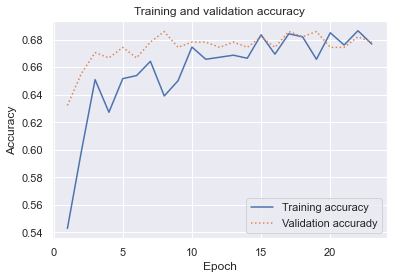

In [415]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accurady')

plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

[]

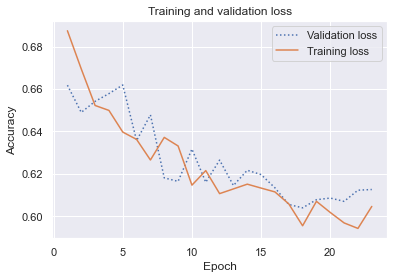

In [416]:
valLoss = hist.history['val_loss']
loss = hist.history['loss']

plt.plot(epochs, valLoss, ':', label='Validation loss')
plt.plot(epochs, loss, '-', label='Training loss')

plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.plot()

In [417]:
y_sex = model.predict(test_scaled)

In [418]:
testCol = pd.DataFrame({'sex': y_sex[:, 0]})
testCol

,sex
0,0.165922
1,0.300572
2,0.162201
3,0.330317
4,0.674706
...,...
256,0.521881
257,0.150326
258,0.803471
259,0.359769


In [419]:
testCol['sex'] = testCol['sex'].round(0).astype('int')
testCol

,sex
0,0
1,0
2,0
3,0
4,1
...,...
256,1
257,0
258,1
259,0


In [420]:
print(f'Accuracy: {accuracy_score(y_test,testCol):.2f}')
print(f'Precision: {precision_score(y_test,testCol):.2f}')
print(f'Recall: {recall_score(y_test,testCol):.2f}')

Accuracy: 0.68
Precision: 0.57
Recall: 0.54


In [421]:
confusion_matrix(y_test,testCol)

array([[125,  40],
       [ 44,  52]], dtype=int64)

In [422]:
testCol.value_counts()

sex
0      169
1       92
dtype: int64

## Embeddings in NN

In [423]:
dfEmb['sex'] = dfEmb['sex'].replace({'female':1, 'male' : 0})
dfEmb['pclass'] = dfEmb['pclass'].replace({1 : 'first', 2 : 'second', 3 : 'third'})
dfEmb

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,first,yes,1,29.000000,0,0,211.3375,Southampton
1,first,yes,0,0.916700,1,2,151.5500,Southampton
2,first,no,1,2.000000,1,2,151.5500,Southampton
3,first,no,0,30.000000,1,2,151.5500,Southampton
4,first,no,1,25.000000,1,2,151.5500,Southampton
...,...,...,...,...,...,...,...,...
1304,third,no,1,14.500000,1,0,14.4542,Cherbourg
1305,third,no,1,29.881135,1,0,14.4542,Cherbourg
1306,third,no,0,26.500000,0,0,7.2250,Cherbourg
1307,third,no,0,27.000000,0,0,7.2250,Cherbourg


In [438]:
#numeric_inputs = tf.keras.layers.Input((4,), name='numeric_inputs')
#cat_inputs = tf.keras.layers.Input((4,), name='cat_inputs')

#
# c_inputs = dfEmb[['pclass','survived','embarked']]
# n_inputs = dfEmb[['age','sibsp','parch','fare']]

In [425]:
from math import sqrt



# Embedding layer for the 'Day of Week' feature
n_unique_class = dfEmb['pclass'].nunique()
n_dim_class = int(sqrt(n_unique_class))
input_class = tf.keras.layers.Input(shape=(1, ))
output_class = tf.keras.layers.Embedding(input_dim=n_unique_class,
                        output_dim=n_dim_class, name="survived")(input_class)
output_class = tf.keras.layers.Reshape(target_shape=(n_dim_class, ))(output_class)


# Embedding layer for the 'Weather' feature
n_unique_survived = dfEmb['survived'].nunique()
n_dim_survived = int(sqrt(n_unique_survived))
input_survived = tf.keras.layers.Input(shape=(1, ))
output_survived = tf.keras.layers.Embedding(input_dim=n_unique_survived,
                           output_dim=n_dim_survived,
                           name="survived")(input_survived)
output_survived = tf.keras.layers.Reshape(target_shape=(n_dim_survived,))(output_survived)

# Embedding layer for the 'Weather' feature
n_unique_embarked = dfEmb['embarked'].nunique()
n_dim_embarked = int(sqrt(n_unique_embarked))
input_embarked = tf.keras.layers.Input(shape=(1, ))
output_embarked = tf.keras.layers.Embedding(input_dim=n_unique_embarked,
                           output_dim=n_dim_embarked,
                           name="embarked")(input_embarked)
output_embarked = tf.keras.layers.Reshape(target_shape=(n_dim_embarked,))(output_embarked)





input_layers = [input_class + input_survived +input_survived]
output_layers = [output_class + output_survived + output_embarked]

model = tf.keras.layers.Concatenate()(output_layers)
# Add a few hidden layers
model = tf.keras.layers.Dense(200, kernel_initializer="uniform")(model)
model = tf.keras.layers.Activation('relu')(model)
model = tf.keras.layers.Dense(100, kernel_initializer="uniform")(model)
model = tf.keras.layers.Activation('relu')(model)
# And finally our output layer
model = tf.keras.layers.Dense(1)(model)
model = tf.keras.layers.Activation('sigmoid')(model)
# Put it all together and compile the model
model = tf.keras.Model(inputs=input_layers, outputs=model)
model.summary()

model.compile(loss='mse', optimizer=tf.optimizers.Adam(0.01), metrics=['mse'])



ValueError: Found input tensor cannot be reached given provided output tensors. Please make sure the tensor KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_46'), name='input_46', description="created by layer 'input_46'") is included in the model inputs when building functional model.

In [457]:
dfEmb['survived'] = dfEmb['survived'].replace({1 : 'yes', 0 : 'no'})

X = dfEmb.drop('sex',axis =1)
y = dfEmb['sex']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=101)

ros = RandomOverSampler(sampling_strategy = "not majority")

X_train, y_train = ros.fit_resample(X_train,y_train)

c_inputs_train = X_train[['pclass','survived','embarked']]
n_inputs_train = X_train[['age','sibsp','parch','fare']]

c_inputs_test = X_test[['pclass','survived','embarked']]
n_inputs_test = X_test[['age','sibsp','parch','fare']]

In [458]:


one_hot_encoded_cat_data_train = pd.DataFrame(enc.fit_transform(c_inputs_train).toarray())
one_hot_encoded_cat_data_test = pd.DataFrame(enc.fit_transform(c_inputs_test).toarray())


no_of_unique_cat  = len(np.unique(c_inputs_train))
#Jeremy Howard provides the following rule of thumb; embedding size = min(50, number of categories/2).
embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
embedding_size = int(embedding_size)

# Use Input layers, specify input shape (dimensions except first)
inp_cat_data = keras.layers.Input(shape=(no_of_unique_cat,))
inp_num_data = keras.layers.Input(shape=(n_inputs_train.shape[1],))
# Bind nulti_hot to embedding layer
emb = keras.layers.Embedding(input_dim=no_of_unique_cat, output_dim=embedding_size)(inp_cat_data)
# Also you need flatten embedded output of shape (?,3,2) to (?, 6) -
# otherwise it's not possible to concatenate it with inp_num_data
flatten = keras.layers.Flatten()(emb)
# Concatenate two layers
conc = keras.layers.Concatenate()([flatten, inp_num_data])
dense1 = keras.layers.Dense(3, activation=tf.nn.relu, )(conc)
# Creating output layer
out = keras.layers.Dense(1, activation=None)(dense1)
model = keras.Model(inputs=[inp_cat_data, inp_num_data], outputs=out)

model.compile(optimizer=tf.optimizers.Adam(0.01),
              loss=keras.losses.mean_squared_error,
              metrics='accuracy')

In [459]:
model.fit([one_hot_encoded_cat_data_train, n_inputs_train], y_train,
          validation_data=([one_hot_encoded_cat_data_test, n_inputs_test], y_test), epochs=23,)

Epoch 1/23
43/43 [==============================] - 0s 3ms/step - loss: 0.3568 - accuracy: 0.5321 - val_loss: 0.2500 - val_accuracy: 0.6336
Epoch 2/23
43/43 [==============================] - 0s 1ms/step - loss: 0.2109 - accuracy: 0.7124 - val_loss: 0.1985 - val_accuracy: 0.7519
Epoch 3/23
43/43 [==============================] - 0s 1ms/step - loss: 0.1784 - accuracy: 0.7715 - val_loss: 0.1855 - val_accuracy: 0.7557
Epoch 4/23
43/43 [==============================] - 0s 1ms/step - loss: 0.1714 - accuracy: 0.7766 - val_loss: 0.1911 - val_accuracy: 0.7405
Epoch 5/23
43/43 [==============================] - 0s 1ms/step - loss: 0.1669 - accuracy: 0.7788 - val_loss: 0.1917 - val_accuracy: 0.7405
Epoch 6/23
43/43 [==============================] - 0s 1ms/step - loss: 0.1749 - accuracy: 0.7737 - val_loss: 0.1796 - val_accuracy: 0.7443
Epoch 7/23
43/43 [==============================] - 0s 1ms/step - loss: 0.1669 - accuracy: 0.7737 - val_loss: 0.1880 - val_accuracy: 0.6870
Epoch 8/23
43/43 [==

In [ ]:
len(y_train)

In [436]:
c_inputs['pclass'] = c_inputs['pclass'].astype('str')

In [442]:
c_inputs

,pclass,survived,embarked
0,first,yes,Southampton
1,first,yes,Southampton
2,first,no,Southampton
3,first,no,Southampton
4,first,no,Southampton
...,...,...,...
1304,third,no,Cherbourg
1305,third,no,Cherbourg
1306,third,no,Cherbourg
1307,third,no,Cherbourg


In [444]:
c_inputs.max()

pclass            third
survived            yes
embarked    Southampton
dtype: object